In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 🟡 **install dependencies**


In [2]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 5.5 MB/s eta 0:00:00


# 🔵 **Imports**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pack_padded_sequence

import torchvision
from torchvision import transforms as T
from torchvision.utils import make_grid
from torchvision import models

from PIL import Image

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

from collections import Counter
import os

from IPython import display

In [4]:
!python --version

Python 3.10.12


In [5]:
for lib in [np, torch, torchvision, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.23.5
torch --> 2.1.0+cu118
torchvision --> 0.16.0+cu118
tqdm --> 4.66.1


# 🔵 **Utils**

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [8]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

# 🔵 **Dataset**

## 🔵 **Load Dataset**

In [ ]:
!unzip /content/drive/MyDrive/uw-madison-gi-tract-image-segmentation.zip  -d /content/

In [10]:
t = pd.read_csv('train.csv')

In [11]:
w, h = 310, 360

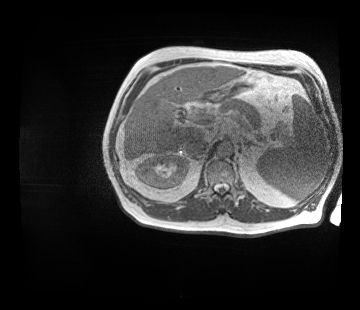

In [12]:
image = Image.open('/content/train/case78/case78_day26/scans/slice_0097_360_310_1.50_1.50.png').convert('RGB')
image

In [13]:
t

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


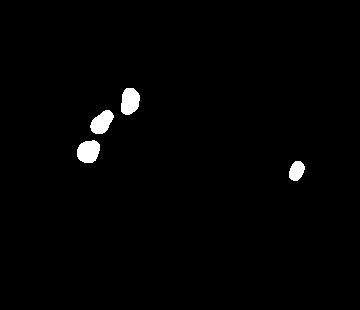

In [14]:
def rle_to_mask(rle, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    rle_pairs = rle.split()
    starts = [int(x) - 1 for x in rle_pairs[0::2]]  # Subtract 1 to convert to 0-based indexing
    lengths = [int(x) for x in rle_pairs[1::2]]

    for start, length in zip(starts, lengths):
        end = start + length
        mask_flat = mask.reshape(-1)
        mask_flat[start:end] = 1

    return mask

# Example usage
rle_encoded = t['segmentation'][12000]
image_shape = (310, 360)  # Shape of the image or mask

mask = rle_to_mask(rle_encoded, image_shape)

# Save the mask as an image
mask_image = Image.fromarray(mask * 255)  # Scale the mask values from [0, 1] to [0, 255]
mask_image

In [15]:
class CleanData():
  def __init__(self, csv_address):

    self.csv_info = pd.read_csv(csv_address)

  def forward(self, text_case_address):

    csv_file = self.new_csv_info(text_case_address)
    return csv_file

  def rle_to_mask(self, rle : str, shape: tuple, seg_cls: int):
    mask = np.zeros(shape, dtype=np.uint8)
    rle_pairs = rle.split()
    starts = [int(x) - 1 for x in rle_pairs[0::2]]  # Subtract 1 to convert to 0-based indexing
    lengths = [int(x) for x in rle_pairs[1::2]]

    for start, length in zip(starts, lengths):
        end = start + length
        mask_flat = mask.reshape(-1)
        mask_flat[start:end] = seg_cls

    mask = torch.tensor(mask)
    return mask

  def new_csv_info(self, text_case_address):
    cases = np.loadtxt(text_case_address, dtype = str).tolist()
    address = []
    for case_n in cases:
      case_plus_day = os.listdir(f'/content/train/{case_n}/')
      for cpd in case_plus_day:
        im_add = os.listdir(f'/content/train/{case_n}/{cpd}/scans/')
        for im in im_add:
          address.append(f'/content/train/{case_n}/{cpd}/scans/{im}')

    new_csv = []
    c = 0
    for i, id in enumerate(self.csv_info['id']):
      id = id.split('_')
      for add in address:
        if f'{id[0]}_{id[1]}' in add and id[3] in add:
          cls = 0
          if str(self.csv_info['segmentation'][i]) == 'nan':
            cls = 0
          else:
            if self.csv_info['class'][i] == 'large_bowel':
              cls = 1
            elif self.csv_info['class'][i] == 'small_bowel':
              cls = 2
            else:
              cls = 3

          shape = (int(add.split('_')[4]), int(add.split('_')[3]))
          new_csv.append([add, self.csv_info['id'][i], cls, self.csv_info['segmentation'][i], shape])

    new_csv = pd.DataFrame(np.array(new_csv), columns = ['Image Address', 'ID', 'Class', 'Segmentation', 'Shape'])

    print('csv file created!')

    return new_csv

In [16]:
clean = CleanData('train.csv')

In [17]:
ans = input('do you have csv file for train, validation and test: (yes or no)')
if ans == 'yes':
  train_csv = pd.read_csv('train_info.csv')
  valid_csv = pd.read_csv('valid_info.csv')
  test_csv  = pd.read_csv('test_info.csv')

if ans == 'no':
  train_csv = clean.forward('train.txt')
  valid_csv = clean.forward('validation.txt')
  test_csv  = clean.forward('test.txt')

  train_csv.to_csv('train_info.csv')
  valid_csv.to_csv('valid_info.csv')
  test_csv.to_csv('test_info.csv')

do you have csv file for train, validation and test: (yes or no)yes


In [18]:
print(f'train size      : {train_csv.shape[0]}')
print(f'validation size : {valid_csv.shape[0]}')
print(f'test size       : {test_csv.shape[0]}')
print(f'total           : {train_csv.shape[0] + valid_csv.shape[0] + test_csv.shape[0]}')

train size      : 82320
validation size : 9504
test size       : 23664
total           : 115488


## 🔵 **EDA**

In [19]:
train_csv.iloc[1995:1998]

,Unnamed: 0,Image Address,ID,Class,Segmentation,Shape
1995,1995,/content/train/case129/case129_day27/scans/sli...,case129_day27_slice_0090,1,45928 8 46286 11 46644 13 47003 15 47362 16 47...,"(310, 360)"
1996,1996,/content/train/case129/case129_day27/scans/sli...,case129_day27_slice_0090,2,38324 10 38681 15 39039 19 39397 22 39728 3 39...,"(310, 360)"
1997,1997,/content/train/case129/case129_day27/scans/sli...,case129_day27_slice_0090,3,38662 2 39021 4 39380 6 39740 6 40100 6 40460 ...,"(310, 360)"


In [20]:
csv_to_show = train_csv.dropna().reset_index().drop(['index', 'Unnamed: 0'], axis = 1)

In [21]:
csv_to_show

,Image Address,ID,Class,Segmentation,Shape
0,/content/train/case129/case129_day20/scans/sli...,case129_day20_slice_0047,1,54203 2 54559 8 54918 10 55277 12 55636 13 559...,"(310, 360)"
1,/content/train/case129/case129_day20/scans/sli...,case129_day20_slice_0047,3,60663 4 61021 8 61379 11 61737 14 62095 16 624...,"(310, 360)"
2,/content/train/case129/case129_day20/scans/sli...,case129_day20_slice_0048,1,52760 4 53118 8 53477 10 53836 13 54196 14 545...,"(310, 360)"
3,/content/train/case129/case129_day20/scans/sli...,case129_day20_slice_0048,3,59224 7 59581 11 59939 14 60298 16 60656 19 61...,"(310, 360)"
4,/content/train/case129/case129_day20/scans/sli...,case129_day20_slice_0049,1,52039 5 52397 9 52756 12 53115 14 53474 16 538...,"(310, 360)"
...,...,...,...,...,...
24519,/content/train/case30/case30_day0/scans/slice_...,case30_day0_slice_0135,2,22540 1 22804 5 23069 7 23334 10 23600 11 2386...,"(266, 266)"
24520,/content/train/case30/case30_day0/scans/slice_...,case30_day0_slice_0136,1,18746 7 19009 23 19038 7 19273 44 19537 49 198...,"(266, 266)"
24521,/content/train/case30/case30_day0/scans/slice_...,case30_day0_slice_0136,2,23079 1 23343 6 23608 9 23874 11 24139 13 2440...,"(266, 266)"
24522,/content/train/case30/case30_day0/scans/slice_...,case30_day0_slice_0137,1,18746 2 19010 8 19040 3 19274 25 19302 12 1953...,"(266, 266)"


In [22]:
import random
def show_maksed_image(N, csv_file):
  images = []
  colors = [[5, 10, 0.0], [0, 1, 0], [0, 5, 2]]
  numbers = random.sample(range(1, csv_file.shape[0]), N)
  labels = ['large bowel', 'small bowel', 'stomach']
  titles = []
  for n in numbers:
    rle = csv_to_show['Segmentation'][n]
    shape = csv_to_show['Shape'][n]
    cls = csv_to_show['Class'][n]
    mask_tensor = clean.rle_to_mask(rle, eval(shape), int(cls))
    image = Image.open(csv_to_show['Image Address'][n]).convert('RGB')
    image_tensor = T.functional.to_tensor(image)
    if cls == 1:
      color = colors[0]
    elif cls == 2:
      color = colors[1]
    else :
      color = colors[2]


    image_tensor[0][mask_tensor == cls] = color[0]
    image_tensor[1][mask_tensor == cls] = color[1]
    image_tensor[2][mask_tensor == cls] = color[2]
    masked = T.functional.to_pil_image(image_tensor)
    images.append(masked)
    titles.append(labels[cls - 1])

  #show all masked images
  if len(images) < 10:
    k, j = 10, 10
  else:
    k, j = len(images), len(images)

  plt.figure(figsize = (k, j))
  if len(images)/2 != int(len(images)/2):
    k, j = len(images), 1
  else:
    k, j = int(len(images)/2), 4
  for i, image in enumerate(images):
    plt.subplot(k, j, i + 1)
    plt.imshow(image)
    plt.title(titles[i])
    plt.axis('off')
    plt.show

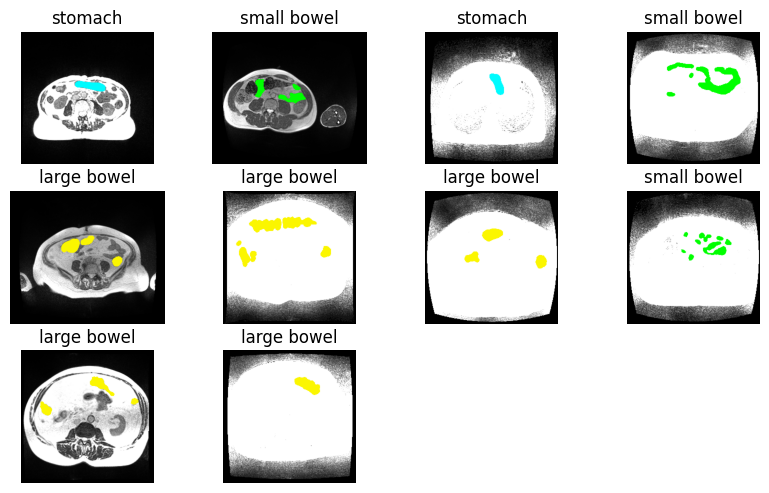

In [23]:
show_maksed_image(10, csv_to_show)

In [24]:
csv_to_show.describe()

,Class
count,24524.000000
mean,1.838852
std,0.800062
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,3.000000


large bowel:10143
small bowel:8190
stomach    :6191


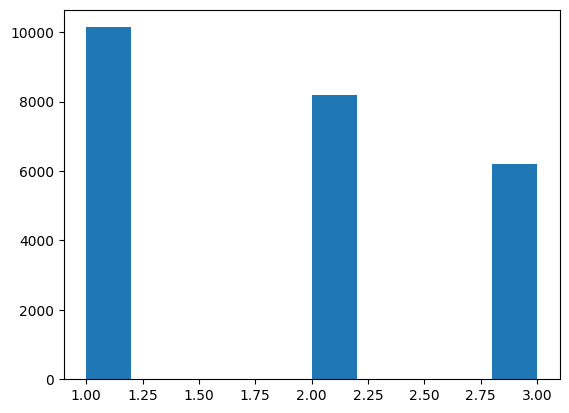

In [25]:
plt.hist(csv_to_show['Class'])
plt.show
print(f"large bowel:{csv_to_show['Class'][csv_to_show['Class'] == 1].count()}")
print(f"small bowel:{csv_to_show['Class'][csv_to_show['Class'] == 2].count()}")
print(f"stomach    :{csv_to_show['Class'][csv_to_show['Class'] == 3].count()}")

(310, 360):7637
(266, 266):15676
(234, 234):117
(276, 276):1094


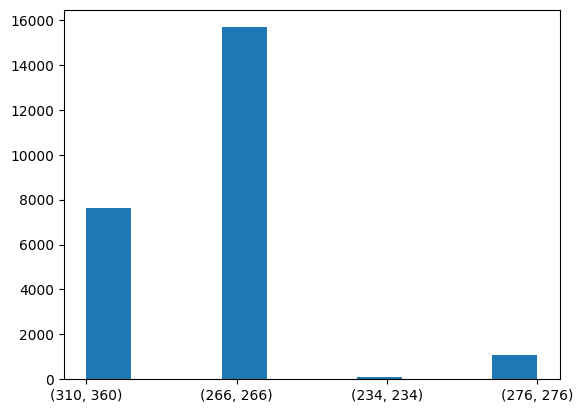

In [26]:
plt.hist(csv_to_show['Shape'])
plt.show
print(f"(310, 360):{csv_to_show['Shape'][csv_to_show['Shape'] == '(310, 360)'].count()}")
print(f"(266, 266):{csv_to_show['Shape'][csv_to_show['Shape'] == '(266, 266)'].count()}")
print(f"(234, 234):{csv_to_show['Shape'][csv_to_show['Shape'] == '(234, 234)'].count()}")
print(f"(276, 276):{csv_to_show['Shape'][csv_to_show['Shape'] == '(276, 276)'].count()}")

## 🔵 **Preprocessing**

In [27]:
train_csv = pd.read_csv('train_info.csv')
valid_csv = pd.read_csv('valid_info.csv')
test_csv  = pd.read_csv('test_info.csv')

In [28]:
def preprocessing(csv_file):

  csv_file = csv_file.dropna().reset_index()
  Image_Address, ID, CLS, Segmentation, Shape = [], [], [], [], []
  ids = list(set(csv_file['ID'].tolist()))

  for i in range(len(ids)):
    s  = csv_file[csv_file['ID'] == ids[i]]
    im_ad = s['Image Address'].iloc[0]
    id    = s['ID'].iloc[0]
    shape = s['Shape'].tolist()[0]
    cls   = s['Class'].tolist()
    seg   = s['Segmentation'].tolist()

    Image_Address.append(im_ad)
    ID.append(id)
    Shape.append(shape)
    CLS.append(cls)
    Segmentation.append(seg)

  return pd.DataFrame(np.transpose(np.array([Image_Address, ID, CLS, Segmentation, Shape])), columns = ['Image Address', 'ID', 'Class', 'Segmentation', 'Shape'])


In [29]:
train_df = preprocessing(train_csv)
valid_df = preprocessing(valid_csv)
test_df  = preprocessing(test_csv)

<ipython-input-28-0eee8f32c5be>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return pd.DataFrame(np.transpose(np.array([Image_Address, ID, CLS, Segmentation, Shape])), columns = ['Image Address', 'ID', 'Class', 'Segmentation', 'Shape'])
<ipython-input-28-0eee8f32c5be>:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return pd.DataFrame(np.transpose(np.array([Image_Address, ID, CLS, Segmentation, Shape])), columns = ['Image Address', 'ID', 'Class', 'Segmentation', 'Shape'])
<ipython-input-28-0eee8f32c5be>:21: VisibleDeprecationWarning: Creating 

In [30]:
print(f'train size : {train_df.shape[0]}')
print(f'valid size : {valid_df.shape[0]}')
print(f'train size : {test_df.shape[0]}')

train size : 12030
valid size : 1493
train size : 3067


In [31]:
train_df.to_csv('train_case.csv')
valid_df.to_csv('valid_case.csv')
test_df.to_csv('test_case.csv')

In [32]:
def new_rle_to_mask(rles, shape : tuple, seg_clss : int):

    shape = eval(shape)
    mask      = np.zeros(shape, dtype=np.uint8)

    for i, rle in enumerate(rles):
      cls   = seg_clss[i]
      rle_pairs = rle.split()
      starts  = [int(x) - 1 for x in rle_pairs[0::2]]  # Subtract 1 to convert to 0-based indexing
      lengths = [int(x) for x in rle_pairs[1::2]]

      for start, length in zip(starts, lengths):
          end       = start + length
          mask_flat = mask.reshape(-1)
          mask_flat[start:end] = cls

    mask = torch.tensor(mask)
    return mask

In [33]:
masked_tensor = new_rle_to_mask(train_df['Segmentation'][2], train_df['Shape'][2], train_df['Class'][2])

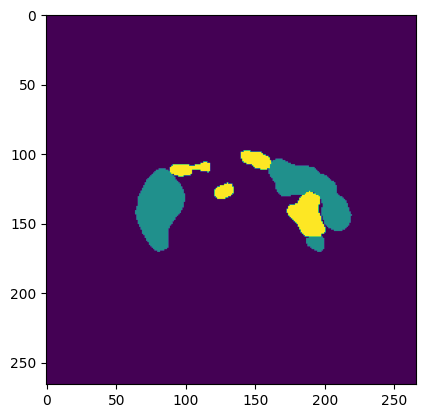

In [34]:

plt.imshow(np.array(masked_tensor))

In [35]:
import random
def show_maksed_image(N, csv_file):
  images = []
  colors = [[100, 0, 0], [0, 100, 0], [0, 0, 100]]
  numbers = random.sample(range(1, csv_file.shape[0]), N)
  labels = ['large bowel', 'small bowel', 'stomach']
  titles = []
  for n in numbers:

    rle = csv_file['Segmentation'][n]
    shape = csv_file['Shape'][n]
    cls = csv_file['Class'][n]

    masked_image = torch.rand(3, eval(shape)[0], eval(shape)[1])

    mask_tensor = new_rle_to_mask(rle, shape, cls)
    image       = Image.open(csv_file['Image Address'][n]).convert('I;16')
    img_array   = np.array(image)

    # Scale the pixel values to the range of 0-255
    img_scaled = (img_array / img_array.max()) * 255

    # Convert the scaled array to a PIL Image
    image = Image.fromarray(img_scaled.astype(np.uint8))

    image_tensor = T.functional.to_tensor(image)[0]
    masked_image[0] = image_tensor
    masked_image[1] = image_tensor
    masked_image[2] = image_tensor

    for cl in cls:
      a = colors[cl - 1]

      masked_image[0][mask_tensor == cl] = cl * a[0]
      masked_image[1][mask_tensor == cl] = cl * a[1]
      masked_image[2][mask_tensor == cl] = cl * a[2]

    masked = T.functional.to_pil_image(masked_image)
    images.append(masked)

  #show all masked images
  if len(images) < 10:
    k, j = 10, 10
  else:
    k, j = len(images), len(images)

  plt.figure(figsize = (k, j))
  if len(images)/2 != int(len(images)/2):
    k, j = len(images), 1
  else:
    k, j = int(len(images)/2), 4

  for i, image in enumerate(images):
    plt.subplot(k, j, i + 1)
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
    plt.show

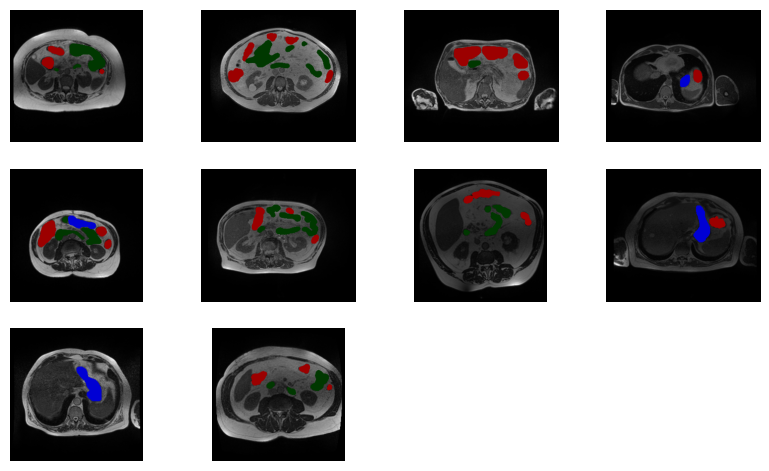

In [36]:
show_maksed_image(10, train_df)

## 🔵 **Custom Dataset**

In [37]:
train_image_transform = T.Compose([T.Resize(size = (256, 256)),
                                   T.ToTensor(),])

In [38]:
class UWMadison(Dataset):

  def __init__(self, csv_file_address, transform):
    super(UWMadison, self).__init__()

    self.data      = pd.read_csv(csv_file_address)
    self.transform = transform

  def __getitem__(self, index):
    image_path  = self.data['Image Address'][index]
    rle_segment = eval(self.data['Segmentation'][index])
    shape       = self.data['Shape'][index]
    clss        = eval(self.data['Class'][index])

    pil_image  = img_array = np.array(Image.open(image_path).convert('I;16'))
    # Scale the pixel values to the range of 0-255
    img_scaled = (img_array / img_array.max()) * 255

    # Convert the scaled array to a PIL Image
    pil_image = Image.fromarray(img_scaled.astype(np.uint8))
    if self.transform:
      image_tensor = self.transform(pil_image)
    else:
      image_tensor = T.Compose([T.Resize(size = (256, 256)),
                                   T.ToTensor(),])(pil_image)

    mask = new_rle_to_mask(rle_segment, shape, clss)
    mask = torch.tensor(mask, dtype = torch.long)
    mask = T.Resize((256, 256))(mask.unsqueeze(0))

    return image_tensor, mask

  def __len__(self):

    return self.data.shape[0]

In [39]:
train_dataset = UWMadison('train_case.csv', train_image_transform)
valid_dataset = UWMadison('valid_case.csv', None)
test_dataset  = UWMadison('test_case.csv', None)

In [40]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(12030, 1493, 3067)

In [41]:
image_tensor, mask = train_dataset[0]

<ipython-input-38-c122c132f8a2>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype = torch.long)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [42]:
image_tensor.shape, mask.shape

(torch.Size([1, 256, 256]), torch.Size([1, 256, 256]))

## 🔵 **Visualize**

In [43]:
def show_random_images_masks(dataset, n):
  random_list = random.sample(range(0, len(dataset)), n)
  for i, index in enumerate(random_list):
    image_tensor, mask = dataset[index]
    plt.subplot(1, n, i + 1)
    plt.subplot(1, 2, 1)
    plt.imshow(T.functional.to_pil_image(image_tensor), cmap = 'gray')
    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(0))
    plt.show()

<ipython-input-38-c122c132f8a2>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype = torch.long)
<ipython-input-43-c8d06c22dbd5>:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


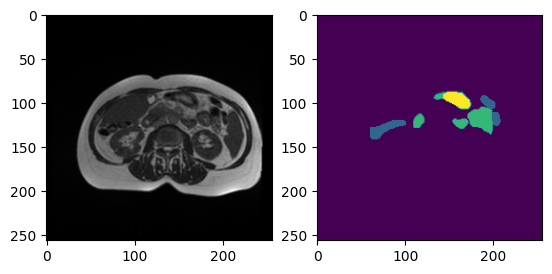

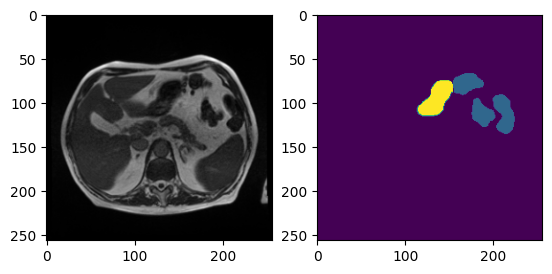

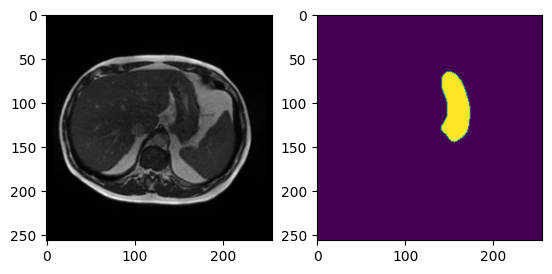

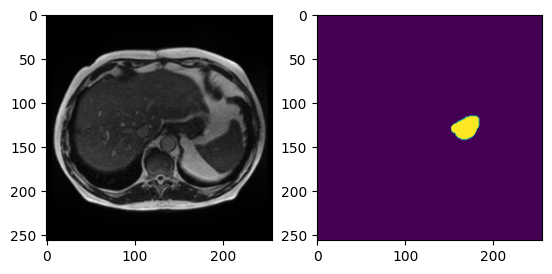

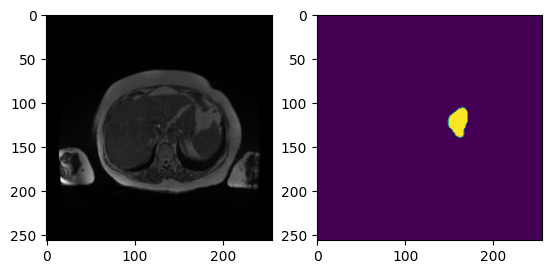

<ipython-input-43-c8d06c22dbd5>:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 2)


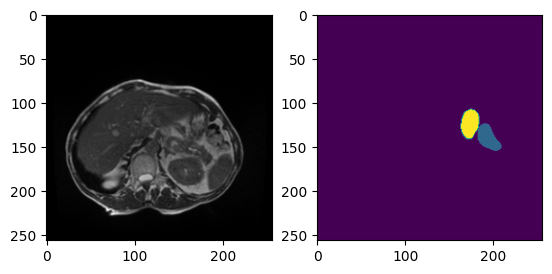

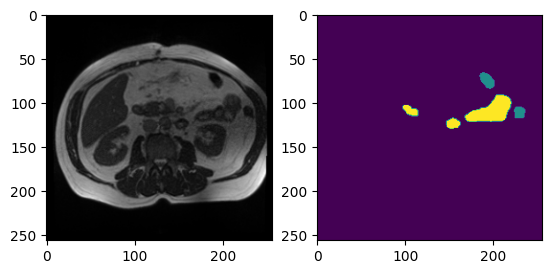

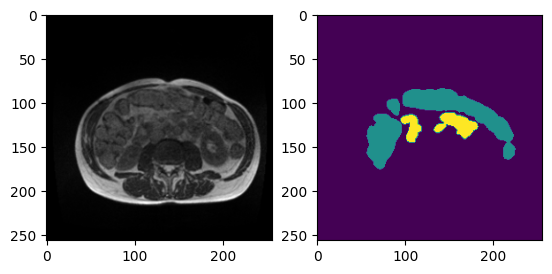

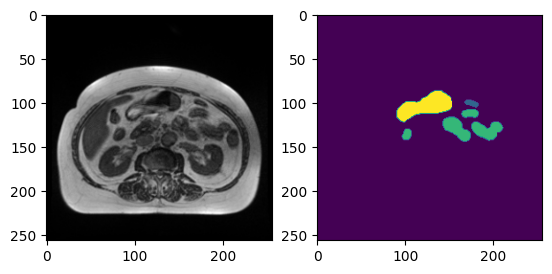

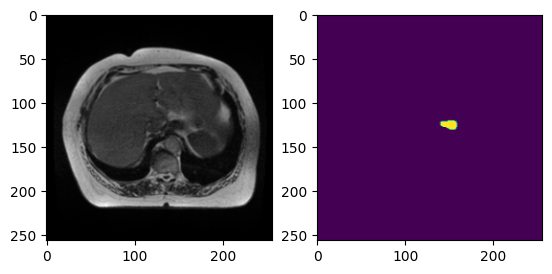

In [44]:
show_random_images_masks(train_dataset, 10)

## 🔵 **DataLoader**

In [45]:
train_loader = DataLoader(train_dataset, batch_size = 4, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 16, shuffle = False)
test_loader  = DataLoader(test_dataset , batch_size = 16, shuffle = False)

In [46]:
image_tensor, mask = next(iter(train_loader))
image_tensor.shape, mask.shape

<ipython-input-38-c122c132f8a2>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype = torch.long)


(torch.Size([4, 1, 256, 256]), torch.Size([4, 1, 256, 256]))

In [47]:
image_tensor, mask = next(iter(valid_loader))
image_tensor.shape, mask.shape

<ipython-input-38-c122c132f8a2>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype = torch.long)


(torch.Size([16, 1, 256, 256]), torch.Size([16, 1, 256, 256]))

In [48]:
image_tensor, mask = next(iter(valid_loader))
image_tensor.shape, mask.shape

<ipython-input-38-c122c132f8a2>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype = torch.long)


(torch.Size([16, 1, 256, 256]), torch.Size([16, 1, 256, 256]))

# 🔵 **Model**

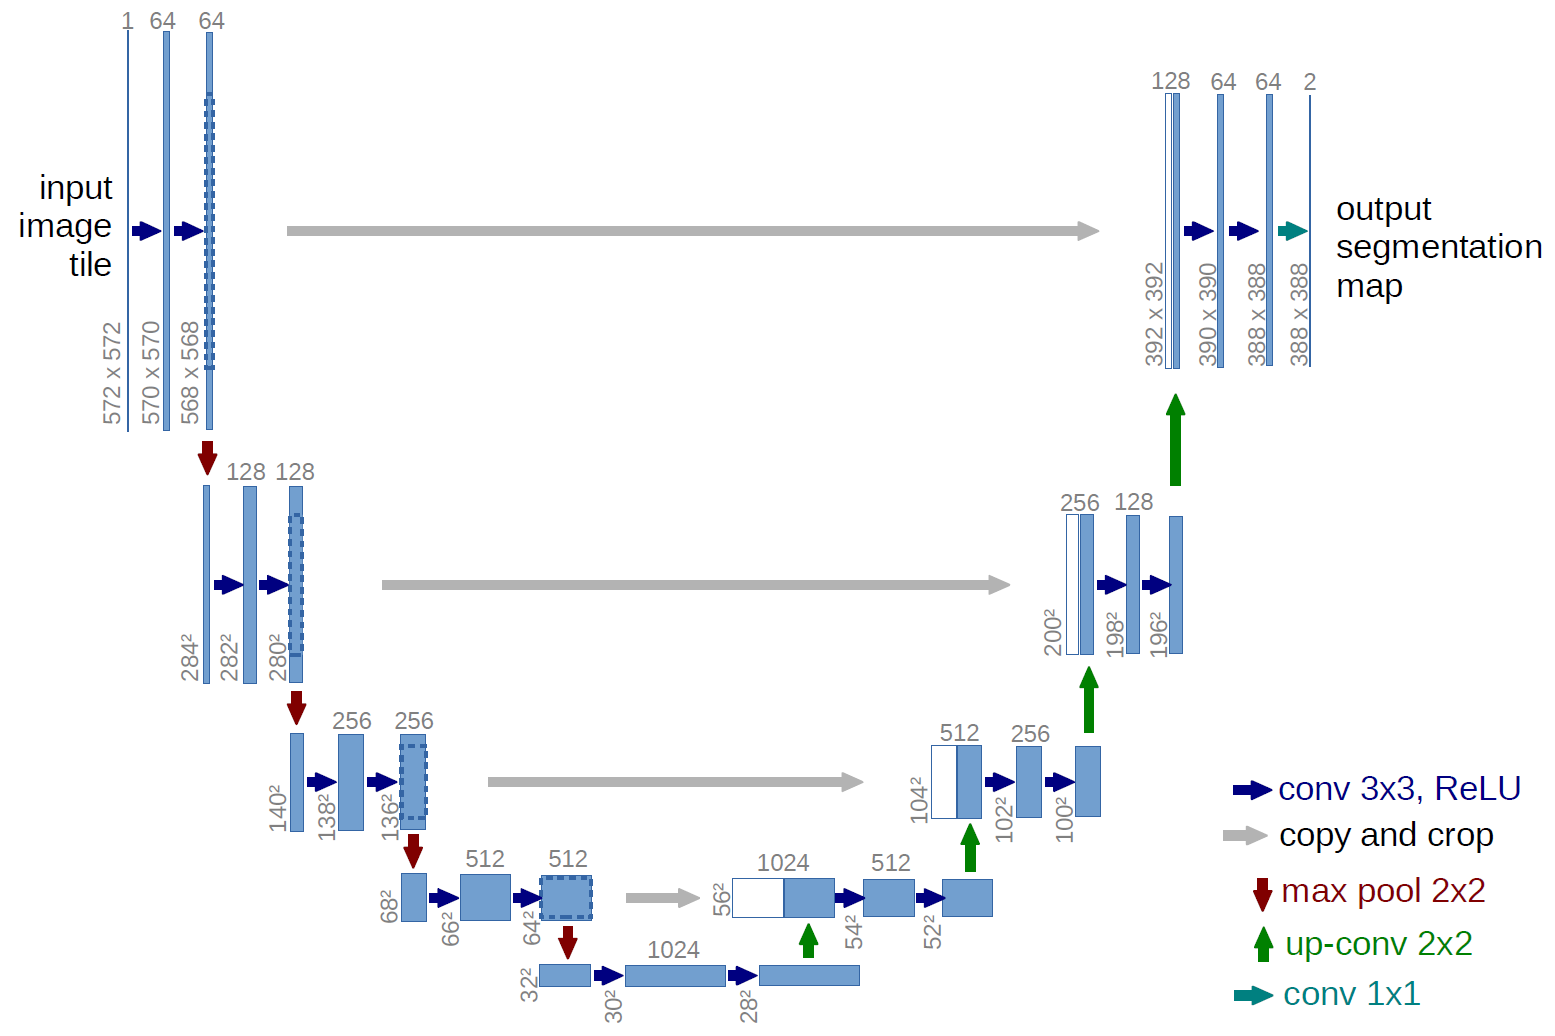

In [49]:
class UNet(nn.Module):

  def __init__(self, in_channels, out_channels, num_classes):
    super(UNet, self).__init__()
    #init contractive path's module
    self.encoder_block1 = self._block(in_channels     , out_channels)
    self.down_sample1   = nn.MaxPool2d(kernel_size = 2, stride  = 2, padding = 0)

    self.encoder_block2 = self._block(out_channels    , out_channels * 2)
    self.down_sample2   = nn.MaxPool2d(kernel_size = 2, stride  = 2, padding = 0)

    self.encoder_block3 = self._block(out_channels * 2, out_channels * 4)
    self.down_sample3   = nn.MaxPool2d(kernel_size = 2, stride  = 2, padding = 0)

    self.encoder_block4 = self._block(out_channels * 4, out_channels * 8)
    self.down_sample4   = nn.MaxPool2d(kernel_size = 2, stride  = 2, padding = 0)

    self.encoder_block5 = self._block(out_channels * 8, out_channels * 16)

    #init expanding path's module
    self.up_sample0     = nn.ConvTranspose2d(out_channels * 16, out_channels * 8 , kernel_size = 2, stride = 2, padding = 0)
    self.decoder_block1 = self._block(out_channels * 16, out_channels * 8)

    self.up_sample1     = nn.ConvTranspose2d(out_channels * 8 , out_channels * 4 , kernel_size = 2, stride = 2, padding = 0)
    self.decoder_block2 = self._block(out_channels * 8 , out_channels * 4)

    self.up_sample2     = nn.ConvTranspose2d(out_channels * 4 , out_channels * 2 , kernel_size = 2, stride = 2, padding = 0)
    self.decoder_block3 = self._block(out_channels * 4 , out_channels * 2)

    self.up_sample3     = nn.ConvTranspose2d(out_channels * 2 , out_channels     , kernel_size = 2, stride = 2, padding = 0)
    self.decoder_block4 = self._block(out_channels * 2 , out_channels    )

    self.cls_head       = nn.Conv2d(out_channels, num_classes, kernel_size  = 1)

  def forward(self, input):
    #Contractive path
    out1_en = self.encoder_block1(input)
    y1      = self.down_sample1(out1_en)
    out2_en = self.encoder_block2(y1)
    y2      = self.down_sample2(out2_en)
    out3_en = self.encoder_block3(y2)
    y3      = self.down_sample3(out3_en)
    out4_en = self.encoder_block4(y3)
    y4      = self.down_sample4(out4_en)
    out5_en = self.encoder_block5(y4)

    #Expanding path
    y5 = self.up_sample0(out5_en)
    y5 = nn.functional.interpolate(y5, size = (out4_en.size(2), out4_en.size(3)), mode = 'nearest')

    y4 = torch.cat([y5, out4_en], dim = 1)
    y4 = self.decoder_block1(y4)
    y4 = self.up_sample1(y4)
    y4 = nn.functional.interpolate(y4, size = (out3_en.size(2), out3_en.size(3)), mode = 'nearest')

    y3 = torch.cat([y4, out3_en], dim = 1)
    y3 = self.decoder_block2(y3)
    y3 = self.up_sample2(y3)
    y3 = nn.functional.interpolate(y3, size = (out2_en.size(2), out2_en.size(3)), mode = 'nearest')

    y2 = torch.cat([y3, out2_en], dim = 1)
    y2 = self.decoder_block3(y2)
    y2 = self.up_sample3(y2)
    y2 = nn.functional.interpolate(y2, size = (out1_en.size(2), out1_en.size(3)), mode = 'nearest')

    y1 = torch.cat([y2, out1_en], dim = 1)
    y1 = self.decoder_block4(y1)

    y  = self.cls_head(y1)

    return y

  def _block(self, in_channels, out_channels):
    block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
                          nn.BatchNorm2d(out_channels),
                          nn.ReLU(),
                          nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1),
                          nn.BatchNorm2d(out_channels),
                          nn.ReLU())
    return block

In [50]:
model = UNet(3, 64, 4)
num_trainable_params(model)

31.043716

In [51]:
class Model(nn.Module):
  def __init__(self, pretrained, scale):
    super(Model, self).__init__()

    self.unet = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=pretrained, scale=scale)
    self.unet.inc.double_conv[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    self.unet.outc.conv = nn.Conv2d(64, 4, (1, 1), stride = (1, 1))

  def forward(self, image_tensor):
    masked = self.unet(image_tensor)

    return masked

In [52]:
model = Model(True, 0.5)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/milesial/Pytorch-UNet/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/milesial/Pytorch-UNet/releases/download/v3.0/unet_carvana_scale0.5_epoch2.pth" to /root/.cache/torch/hub/checkpoints/unet_carvana_scale0.5_epoch2.pth
100%|██████████| 118M/118M [00:00<00:00, 250MB/s] 


In [53]:
model(image_tensor).shape

torch.Size([16, 4, 256, 256])

In [54]:
image_tensor.shape

torch.Size([16, 1, 256, 256])

# 🔵 **Config**

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [56]:
loss_func = nn.CrossEntropyLoss()
metric_bleu = tm.Dice().to(device)

# 🔵 **Train**

In [57]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, shedular, metric, alpha, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, masks in tepoch:
      if epoch or epoch == 0:
        tepoch.set_description(f'Epoch {epoch}')


      inputs  = inputs.to(device)
      masks   = masks.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, masks.squeeze(1)) + alpha * (1 - metric(outputs, masks))

      loss.backward()


      optimizer.step()
      if shedular:
        shedular.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(masks))
      metric.update(outputs, masks)


      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔵 **Evaluation**

In [58]:
def evaluate(model, data_loader, loss_fn, metric):
  model.eval()
  metric.reset()

  loss_valid = AverageMeter()

  for inputs, masks in data_loader:

    inputs = inputs.to(device)
    masks   = masks.to(device)

    with torch.no_grad():
      outputs = model(inputs)

    loss = loss_fn(outputs, masks.squeeze(1))
    loss_valid.update(loss)
    metric.update(outputs, masks)

  print(f'Loss : {loss_valid.avg.item()}, Metric : {metric.compute().item()}')

  return loss_valid.avg.item(), metric.compute().item()

# 🔵 **Training Process**

## 🔵 **Step 1**

In [ ]:
loss_func = nn.CrossEntropyLoss(ignore_index = 0)
metric    = tm.Dice(ignore_index = 0).to(device)

In [ ]:
model = Model(False, 0).to(device)

Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


In [ ]:
image_tensor, mask = next(iter(train_loader))

<ipython-input-323-9afdb48f4a99>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype = torch.long)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
<ipy

In [ ]:
mask_pred = model(image_tensor.to(device))

In [ ]:
loss_func(mask_pred, mask.squeeze(1).to(device))

tensor(1.2093, device='cuda:0', grad_fn=<NllLoss2DBackward0>)

In [ ]:
metric(mask_pred, mask.to(device))

tensor(0.0417, device='cuda:0')

## 🔵 **Step 2**

In [ ]:
torch.cuda.empty_cache()

In [ ]:
model = Model(False, 0).to(device)
num_trainable_params(model)

Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


31.036676

In [ ]:
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
loss_func = nn.CrossEntropyLoss(weight=torch.tensor([0.02, 0.9, 0.9, 0.9]).to(device))
metric    = tm.Dice(ignore_index = 0).to(device)

In [ ]:
sub_set, _ = random_split(train_dataset, (100, len(train_dataset) - 100))
len(sub_set)

100

In [ ]:
sub_loader = DataLoader(sub_set, batch_size = 2, shuffle = True)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, sub_loader, loss_func, optimizer, None, metric, epoch)

  0%|          | 0/50 [00:00<?, ?batch/s]<ipython-input-323-9afdb48f4a99>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype = torch.long)
Epoch 99: 100%|██████████| 50/50 [00:07<00:00,  7.05batch/s, loss=0.0448, metric=0.902]


In [ ]:
im, msk = next(iter(sub_loader))

<ipython-input-323-9afdb48f4a99>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype = torch.long)


In [ ]:
pred = model(im.to(device))

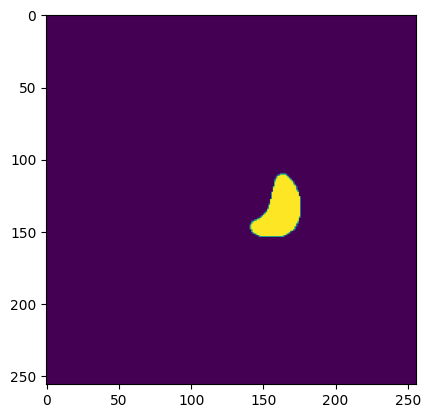

In [ ]:
plt.imshow(np.array(msk[1].squeeze(0)))

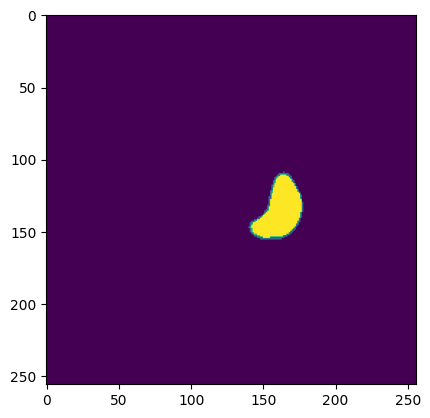

In [ ]:
plt.imshow(np.array(pred[1].argmax(dim = 0).cpu()))

## 🔵 **Step 3**

In [ ]:
num_epochs = 5
lr_list    = [0.5, 0.1, 0.01]
results    = []

for lr in lr_list:
  sub_result = []
  print(f'LR={lr}')

  model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5).to(device)
  model.outc.conv = nn.Conv2d(64, 4, (1, 1), stride = (1, 1)).to(device)

  optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
  loss_func = nn.CrossEntropyLoss(weight=torch.tensor([0.01, 0.33, 0.33, 0.33]).to(device))
  metric    = tm.Dice(ignore_index = 0).to(device)

  for epoch in range(num_epochs):
    model, train_loss, _ = train_one_epoch(model, train_loader, loss_func, optimizer, metric, epoch)

    if epoch == 0:
      sub_result.append(train_loss)
    if epoch == 4:
      sub_result.append(train_loss)

  results.append(sub_result)

  print()

LR=0.5


Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master
  0%|          | 0/3008 [00:00<?, ?batch/s]<ipython-input-47-a1d52a131d7e>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype = torch.long)
Epoch 4: 100%|██████████| 3008/3008 [13:34<00:00,  3.69batch/s, loss=0.662, metric=0.26]



LR=0.1


Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master
Epoch 4: 100%|██████████| 3008/3008 [13:41<00:00,  3.66batch/s, loss=0.445, metric=0.372]



LR=0.01


Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master
Epoch 4: 100%|██████████| 3008/3008 [13:47<00:00,  3.64batch/s, loss=0.409, metric=0.397]

In [ ]:
pd.DataFrame(np.array(results), index = lr_list)

,0,1
0.50,0.893587,0.662365
0.10,0.763706,0.444825
0.01,0.700006,0.408651


## 🔵 **Step 4**

In [ ]:

lr_list = [0.01]
wd_list = [0, 1e-5, 1e-6]
result  = []
indexes = []

for lr in lr_list:
  for wd in wd_list:

    print(f'LR = {lr}, Weight_decay = {wd}')
    indexes.append(f'LR = {lr}, Weight_decay = {wd}')

    sub_result = []

    model = torch.hub.load('milesial/Pytorch-UNet', 'unet_carvana', pretrained=True, scale=0.5).to(device)
    model.outc.conv = nn.Conv2d(64, 4, (1, 1), stride = (1, 1)).to(device)

    optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
    loss_func = nn.CrossEntropyLoss(weight=torch.tensor([0.01, 0.33, 0.33, 0.33]).to(device))
    metric    = tm.Dice(ignore_index = 0).to(device)

    for i in range(4):
      model, train_loss, metric_train = train_one_epoch(model, train_loader, loss_func, optimizer, metric, i)
      valid_loss, metric_valid        = evaluate(model, valid_loader, loss_func, metric)

      if i == 0:
        sub_result.append(train_loss)
        sub_result.append(valid_loss)
      if i == 3:
        sub_result.append(train_loss)
        sub_result.append(valid_loss)

    result.append(sub_result)
    torch.save(model, f'/content/models-step4/model*{lr}*{wd}.pt')
    print('model saved!')
    print('---------------------------------------------')

LR = 0.01, Weight_decay = 0


Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master
  0%|          | 0/3008 [00:00<?, ?batch/s]<ipython-input-38-60cd021a2aa4>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype = torch.long)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inferen

Loss : 0.7655794620513916, Metric : 0.22543440759181976


Epoch 1: 100%|██████████| 3008/3008 [13:28<00:00,  3.72batch/s, loss=0.557, metric=0.3]


Loss : 0.6795793771743774, Metric : 0.26927343010902405


Epoch 2: 100%|██████████| 3008/3008 [13:28<00:00,  3.72batch/s, loss=0.487, metric=0.343]


Loss : 0.7333955764770508, Metric : 0.252791166305542


Epoch 3: 100%|██████████| 3008/3008 [13:28<00:00,  3.72batch/s, loss=0.438, metric=0.373]


Loss : 0.6351662278175354, Metric : 0.3073917329311371
model saved!
---------------------------------------------
LR = 0.01, Weight_decay = 1e-05


Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master
Epoch 0: 100%|██████████| 3008/3008 [13:24<00:00,  3.74batch/s, loss=0.728, metric=0.208]


Loss : 2.362813949584961, Metric : 0.1572805643081665


Epoch 1: 100%|██████████| 3008/3008 [13:25<00:00,  3.73batch/s, loss=0.59, metric=0.285]


Loss : 0.77141273021698, Metric : 0.2912321090698242


Epoch 2: 100%|██████████| 3008/3008 [13:25<00:00,  3.73batch/s, loss=0.521, metric=0.326]


Loss : 0.8012714982032776, Metric : 0.2890486419200897


Epoch 3: 100%|██████████| 3008/3008 [13:26<00:00,  3.73batch/s, loss=0.464, metric=0.361]


Loss : 0.6537125706672668, Metric : 0.3276565670967102
model saved!
---------------------------------------------
LR = 0.01, Weight_decay = 1e-06


Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master
Epoch 0: 100%|██████████| 3008/3008 [13:24<00:00,  3.74batch/s, loss=0.7, metric=0.223]


Loss : 0.7690902948379517, Metric : 0.21038979291915894


Epoch 1: 100%|██████████| 3008/3008 [13:25<00:00,  3.74batch/s, loss=0.572, metric=0.297]


Loss : 0.6810038685798645, Metric : 0.27121224999427795


Epoch 2: 100%|██████████| 3008/3008 [13:26<00:00,  3.73batch/s, loss=0.505, metric=0.334]


Loss : 0.7528805136680603, Metric : 0.3056686222553253


Epoch 3: 100%|██████████| 3008/3008 [13:25<00:00,  3.73batch/s, loss=0.453, metric=0.367]


Loss : 0.6477495431900024, Metric : 0.2947801351547241
model saved!
---------------------------------------------


In [ ]:
pd.DataFrame(result, index = indexes, columns = ['start train loss', 'start valid loss', 'stop train loss', 'stop valid loss'])

,start train loss,start valid loss,stop train loss,stop valid loss
"LR = 0.01, Weight_decay = 0",0.713956,0.765579,0.437946,0.635166
"LR = 0.01, Weight_decay = 1e-05",0.727801,2.362814,0.464004,0.653713
"LR = 0.01, Weight_decay = 1e-06",0.699641,0.769090,0.452557,0.647750


## 🔵 **Step 5**

In [ ]:
model = torch.load('models-step4/model*0.01*0.pt').to(device)

In [ ]:
lr, wd = 0.01, 0
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)
loss_func = nn.CrossEntropyLoss(weight = torch.tensor([0.01, 0.33, 0.33, 0.33]).to(device))
metric    = tm.Dice(ignore_index = 0).to(device)

In [ ]:
start, stop = 0, 5
for i in range(start, stop):

  model, _, _ = train_one_epoch(model, train_loader, loss_func, optimizer, metric, i)
  _, _        = evaluate(model, valid_loader, loss_func, metric)

  0%|          | 0/3008 [00:00<?, ?batch/s]<ipython-input-38-60cd021a2aa4>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype = torch.long)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfo

Loss : 0.653032660484314, Metric : 0.28806039690971375


Epoch 1: 100%|██████████| 3008/3008 [13:25<00:00,  3.73batch/s, loss=0.368, metric=0.42]


Loss : 0.733858585357666, Metric : 0.3083687126636505


Epoch 2: 100%|██████████| 3008/3008 [13:25<00:00,  3.73batch/s, loss=0.337, metric=0.443]


Loss : 0.7397584915161133, Metric : 0.3292551338672638


Epoch 3: 100%|██████████| 3008/3008 [13:25<00:00,  3.73batch/s, loss=0.311, metric=0.462]


Loss : 0.6904017329216003, Metric : 0.33467167615890503


Epoch 4: 100%|██████████| 3008/3008 [13:25<00:00,  3.73batch/s, loss=0.285, metric=0.485]


Loss : 0.8051912784576416, Metric : 0.3374788761138916


## 🔵 **Main Loop**

In [59]:
set_seed(42)
model = Model(False, 0.0).to(device)
num_trainable_params(model)

Using cache found in /root/.cache/torch/hub/milesial_Pytorch-UNet_master


31.036676

In [60]:
set_seed(42)
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 2)

In [61]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist  =[], []
best_metric = 0

In [79]:
lr = 0.001
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 20000, eta_min = 1e-4)
loss_func_train = nn.CrossEntropyLoss(weight = torch.tensor([0.4, 0.8, 0.8, 0.8]).to(device))
loss_func = nn.CrossEntropyLoss(ignore_index = 0)
metric    = tm.Dice(ignore_index = 0).to(device)

In [80]:
set_seed(42)

start, stop = 15, 17
wait = 0

for i in range(start, stop):

  model, train_loss, train_metric = train_one_epoch(model, train_loader, loss_func_train, optimizer, None, metric, 0.1, i)
  valid_loss, valid_metric        = evaluate(model, valid_loader, loss_func_train, metric)

  train_loss_hist.append(train_loss)
  valid_loss_hist.append(valid_loss)
  train_metric_hist.append(train_metric)
  valid_metric_hist.append(valid_metric)

  if valid_metric>best_metric:

    torch.save(model, 'best_model.pt')
    print('model saved!')
    wait = 0
    best_metric = valid_metric

  else:
    wait += 1
    if wait >= 1 and i >= 9:
      lr = 0.5 * lr
      optimizer = optim.SGD(model.parameters(), lr = lr, momentum = 0.9, weight_decay = wd)
      wait = 0

  0%|          | 0/752 [00:00<?, ?batch/s]<ipython-input-38-c122c132f8a2>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype = torch.long)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transfor

Loss : 0.0908690094947815, Metric : 0.7764290571212769
model saved!


Epoch 16: 100%|██████████| 752/752 [09:30<00:00,  1.32batch/s, loss=0.0367, metric=0.897]


Loss : 0.09213627129793167, Metric : 0.7760121822357178


### 🔵 **Plot**

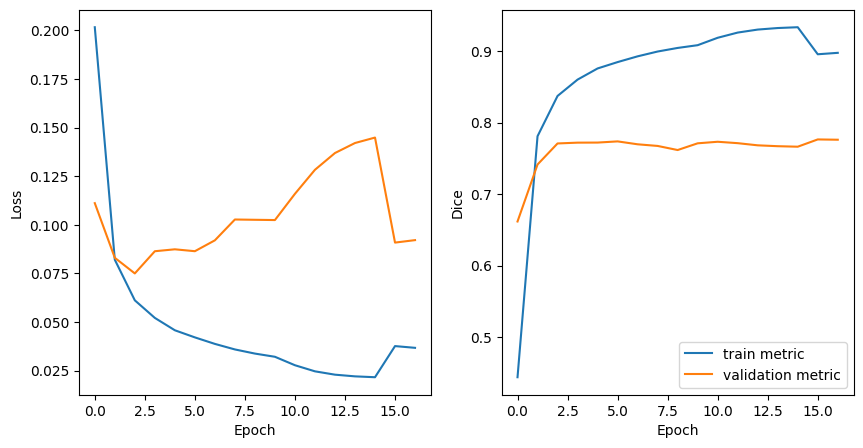

In [81]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(stop), train_loss_hist, label = 'train loss')
plt.plot(range(stop), valid_loss_hist, label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_metric_hist, label = 'train metric')
plt.plot(valid_metric_hist, label = 'validation metric')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.legend()
plt.show()

# 🔵 **Test**

In [82]:
model = torch.load('best_model.pt').to(device).eval()

In [83]:
loss_func = nn.CrossEntropyLoss(ignore_index = 0)
metric    = tm.Dice(ignore_index = 0).to(device)

In [84]:
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func_train, metric)

<ipython-input-38-c122c132f8a2>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype = torch.long)


Loss : 0.08008062839508057, Metric : 0.7634135484695435


# 🔵 **Segment**

In [85]:
model = torch.load('best_model.pt').to(device).eval()

In [86]:
def segment_image(model, pil_image, transform, ground_truth, metric, classes_name_list):
  model.eval()
  metric.reset()

  colors = [[100, 0, 0], [0, 100, 0], [0, 0, 100]]

  ground_truth = torch.tensor(ground_truth, dtype = torch.long)

  if transform:
    image_tensor = transform(pil_image)
    ground_truth = T.Resize((256, 256))(ground_truth.unsqueeze(0))
  else:
    image_tensor = T.functional.to_tensor(pil_image)

  with torch.no_grad():
    mask_pred = model(image_tensor.unsqueeze(0).to(device))

  print('Loss:::', loss_func(mask_pred, ground_truth.to(device)).item())
  print('Dice:::', metric(mask_pred, ground_truth.to(device)).item())

  mask_pred = mask_pred.argmax(dim = 1).squeeze(0).cpu()

  masked_image = torch.zeros(3, mask_pred.shape[-2], mask_pred.shape[-1])

  masked_image[0] = image_tensor
  masked_image[1] = image_tensor
  masked_image[2] = image_tensor

  for cl in [1, 2, 3]:
    a = colors[cl - 1]

    masked_image[0][mask_pred == cl] = cl * a[0]
    masked_image[1][mask_pred == cl] = cl * a[1]
    masked_image[2][mask_pred == cl] = cl * a[2]

  plt.figure(figsize = (10, 5))
  plt.subplot(1, 3, 1)
  plt.imshow(T.functional.to_pil_image(masked_image))
  plt.title('Segmented image')
  plt.axis('off')
  plt.subplot(1, 3, 2)
  plt.imshow(np.array(mask_pred))
  plt.title('Predicted Mask')
  plt.axis('off')
  plt.subplot(1, 3, 3)
  plt.imshow(np.array(ground_truth.squeeze(0)))
  plt.title('Ground Truth')
  plt.axis('off')
  plt.show()


Loss::: 1.1800392866134644
Dice::: 0.780515730381012


<ipython-input-86-774c81e4a9ed>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ground_truth = torch.tensor(ground_truth, dtype = torch.long)


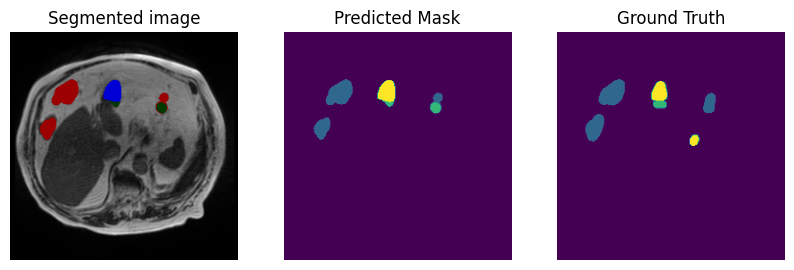

Loss::: 0.6417914628982544
Dice::: 0.8676286339759827


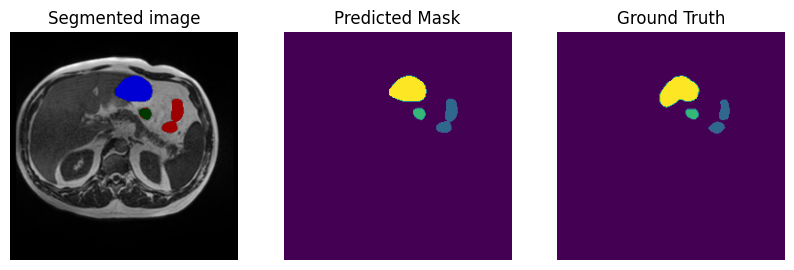

Loss::: 0.7803502082824707
Dice::: 0.6570345759391785


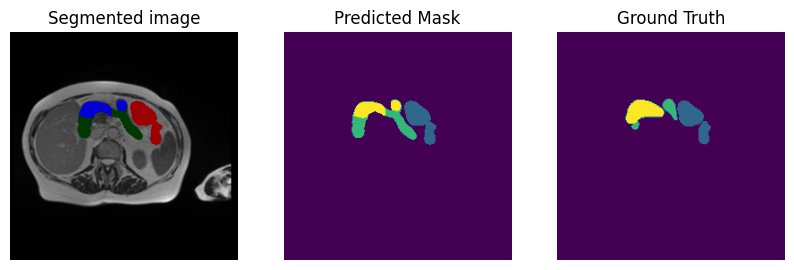

Loss::: 0.5217518210411072
Dice::: 0.8007917404174805


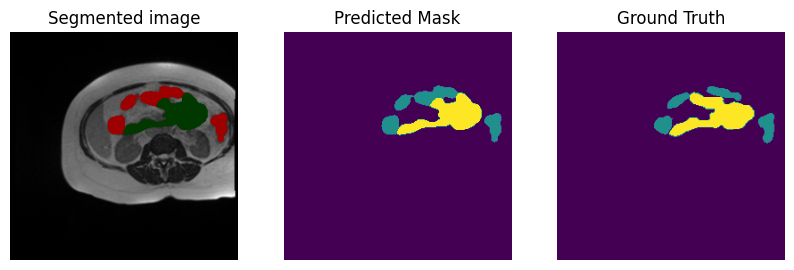

Loss::: 0.843460738658905
Dice::: 0.7377049326896667


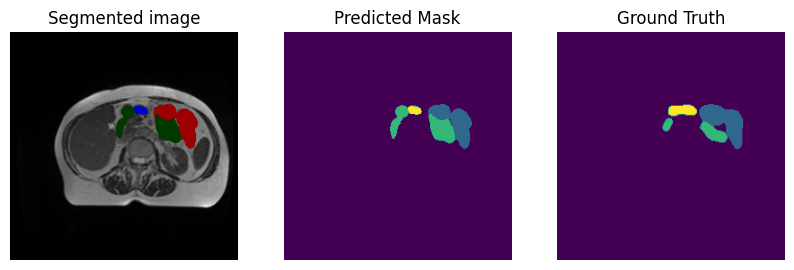

Loss::: 1.0073922872543335
Dice::: 0.7237485647201538


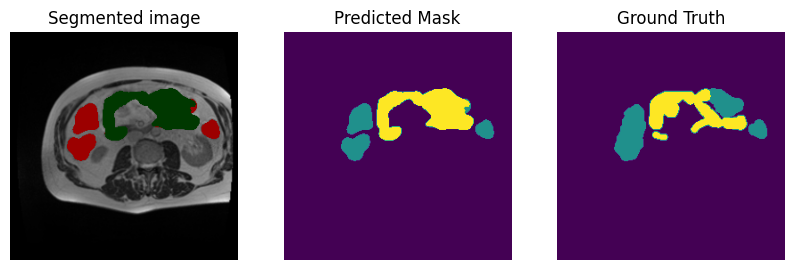

In [87]:
transform = train_image_transform = T.Compose([T.Resize(size = (256, 256)),
                                    T.ToTensor(),])
id_list = [369, 396, 639, 693, 936, 963]
for id in id_list:
  address = test_df['Image Address'][id]
  rle     = test_df['Segmentation'][id]
  cls     = test_df['Class'][id]
  shape   = test_df['Shape'][id]

  mask      = new_rle_to_mask(rle, shape, cls)
  img_array = np.array(Image.open(address).convert('I;16'))

  # Scale the pixel values to the range of 0-255
  img_scaled = (img_array / img_array.max()) * 255

  # Convert the scaled array to a PIL Image
  pil_image = Image.fromarray(img_scaled.astype(np.uint8))

  metric = tm.Dice(ignore_index = 0).to(device)

  cls_name = ['back ground', 'large bowel', 'small bowel', 'stomach']

  segment_image(model, pil_image, transform, mask, metric, cls_name)